# A behavioural analog to BCI training : results

Statistics and simple plots of the results of the experiment (technical test). 

This notebook does not figure much computational modeling (yet).


Let's start by importing the necessary packages as well as the data : 

 - Loaded the task results for study 66f96c31e69227986334a027 
    (16 subjects.)
 - Loaded the task results for study 66d086503c0a69291c361b67 
    (40 subjects.)
Total : 56 subjects
55 subjects remaining after removing problematic subjects.
A total of 14/6050 actions were missed. (0.23 %)
 - Loaded the task results for study 6703ab18d345eaa4893587e0 
    (49 subjects.)
 - Loaded the task results for study 66f9aee8210357265a5958fc 
    (50 subjects.)
 - Loaded the task results for study 6703ab1a7ea30557549dc6da 
    (50 subjects.)
Total : 149 subjects
145 subjects remaining after removing problematic subjects.
A total of 33/15950 actions were missed. (0.21 %)
(200, 3)


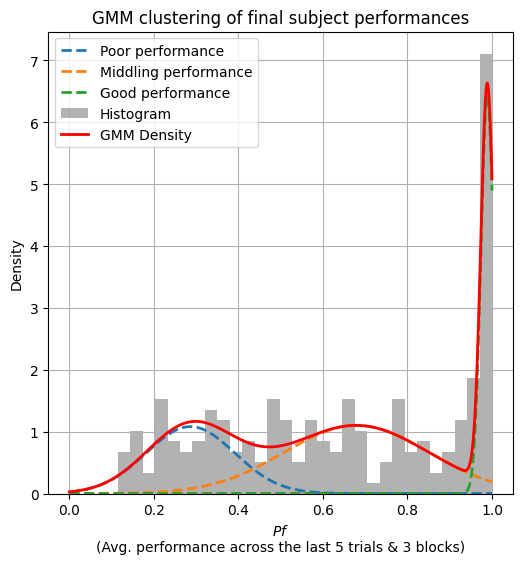

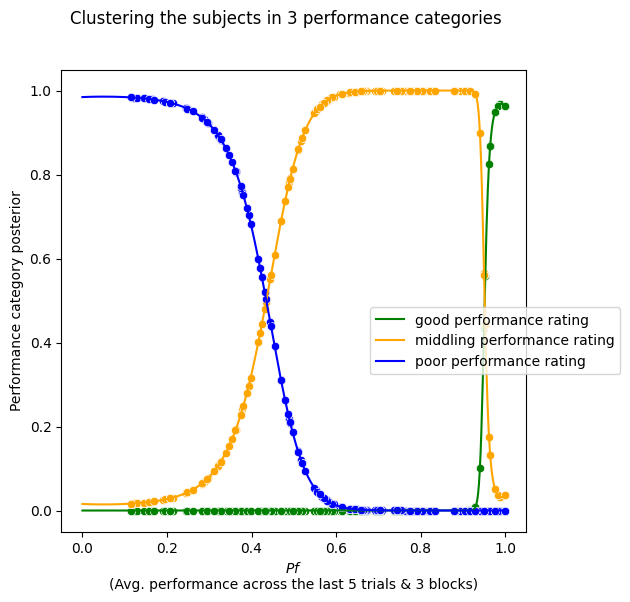

c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\analysis_tools\dataframe_from_raw_data.py:348: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


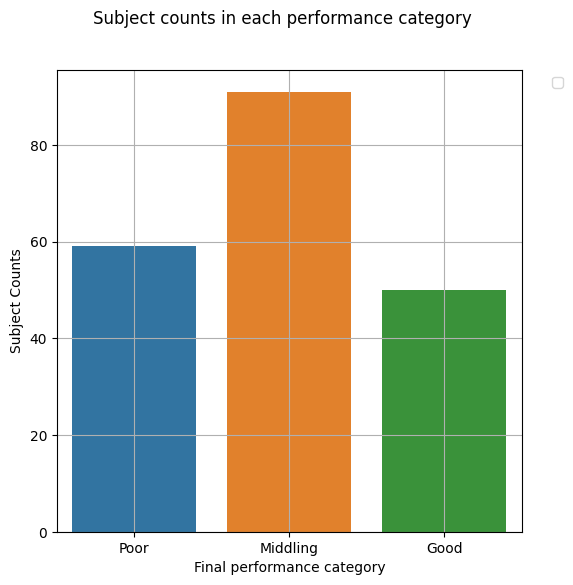

In [1]:

import sys,os
import pickle

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly as pltly
import plotly.express as px
import plotly.graph_objects as go

from sklearn.mixture import GaussianMixture

from jax import vmap
import jax.numpy as jnp

# + local functions : 
from database_handling.database_extract import get_all_subject_data_from_internal_task_id
from utils import remove_by_indices
from analysis_tools.preprocess import get_preprocessed_data_from_df
from analysis_tools.dataframe_from_raw_data import get_full_dataframe_from_raw_data

LLM_CLASSIFS_PATH = os.path.join("results","llm_classifications","29_01.data")

STUDIES_EXTRACTION_CODES = {
    # "study_1" : {
    #     "dict_code" : "002",
    #     "internal_task_id" : "002",
    #     "studies_id" : None,
    #     "exclude_subjects" : ["5c9cb670b472d0001295f377"],
    #     "feedback_noise_bins" : [0,0.2,0.4,1]
    # },
    "study_2" : {
        "dict_code" : "003_1",
        "internal_task_id" : "003",
        "studies_id" :  ["66f96c31e69227986334a027","66d086503c0a69291c361b67"],
        "exclude_subjects" : ["615c1741d4630b25e6bc1cb9"],
        "feedback_noise_bins" : [0,0.05,0.15,1]
    },
    "study_3" : {
        "dict_code" : "003_2",
        "internal_task_id" : "003",
        "studies_id" : ["6703ab18d345eaa4893587e0","66f9aee8210357265a5958fc","6703ab1a7ea30557549dc6da"],
        "exclude_subjects" : ["611d60c383f4f70ff4bc99fd", "66a74bdfdcaccdc0703894d5",
                              "667d92f2ea5c1542f417285d", "6548f570022275786186ffbd"],
        "feedback_noise_bins" : [0,0.05,0.15,1]
    }
}

LAST_T_TIMESTEPS = 5
LAST_K_TRIALS = 3
subjects_df = get_full_dataframe_from_raw_data(STUDIES_EXTRACTION_CODES,LLM_CLASSIFS_PATH,LAST_T_TIMESTEPS,LAST_K_TRIALS)

## Interesting questions : 

How do our participants decision-making evolve when they get a negative feedback ? A positive feedback ?


In [2]:
print(subjects_df.keys())

copy_df = subjects_df[subjects_df["study_name"]=="study_3"]

# Difference between raw points at times t and t+1
points = np.stack(copy_df["raw_points"])

Nsubj,Ntrials,Nactions,Npoints,Nfeatures = points.shape

points_1 = points[...,0,:2]
points_2 = points[...,1,:2]
dist_points1 = np.linalg.norm(points_1[:,:,:-1,:] - points_1[:,:,1:,:],axis=-1)
dist_points2 = np.linalg.norm(points_2[:,:,:-1,:] - points_2[:,:,1:,:],axis=-1)
avg_dist = (dist_points1 + dist_points2)/2.0
flattened_distance = np.reshape(avg_dist,(Nsubj,-1))
copy_df["dist_between_successive"] = list(flattened_distance)


Index(['subject_id', 'task_code', 'lang', 'browser', 'N_trials', 'N_tmstps',
       'start_date', 'finish_date', 'finished_clock', 'completedTask',
       'N_exited_fullscreen', 'N_missed_actions', 'canvas_explore_points',
       'mandatory_q1', 'mandatory_q2', 'optional_q1', 'optional_q2',
       'optional_q3', 'canvas_size', 'Submission id', 'Participant id',
       'Status', 'Custom study tncs accepted at', 'Started at', 'Completed at',
       'Reviewed at', 'Archived at', 'Time taken', 'Completion code',
       'Total approvals', 'Fluent languages', 'Age', 'Sex',
       'Ethnicity simplified', 'Country of birth', 'Country of residence',
       'Nationality', 'Language', 'Student status', 'Employment status',
       'Nationality_red', 'feedback_noise_std',
       'application_measured_timetaken', 'question_0', 'question_1',
       'question_2', 'question_3', 'question_4', 'question_5',
       'raw_feedback_values', 'raw_realtime_values', 'realtime_values',
       'grid_layout', 'sub

C:\Users\annic\AppData\Local\Temp\ipykernel_27216\1599574293.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copy_df["dist_between_successive"] = list(flattened_distance)


The exploration / exploitation shift is clearly visible in the last category of subjects, with a distinct decrease in the average variation in point position. This is far less visible in less successful subject categories.

Question : for a single action modality, how does the intensity of a variation relate to the variation of the other modalities.

C:\Users\annic\AppData\Local\Temp\ipykernel_27216\2960974303.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[label] = list(dnext_act)
C:\Users\annic\AppData\Local\Temp\ipykernel_27216\2960974303.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["delta_gauges"] = list(dgaug)
C:\Users\annic\AppData\Local\Temp\ipykernel_27216\2960974303.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

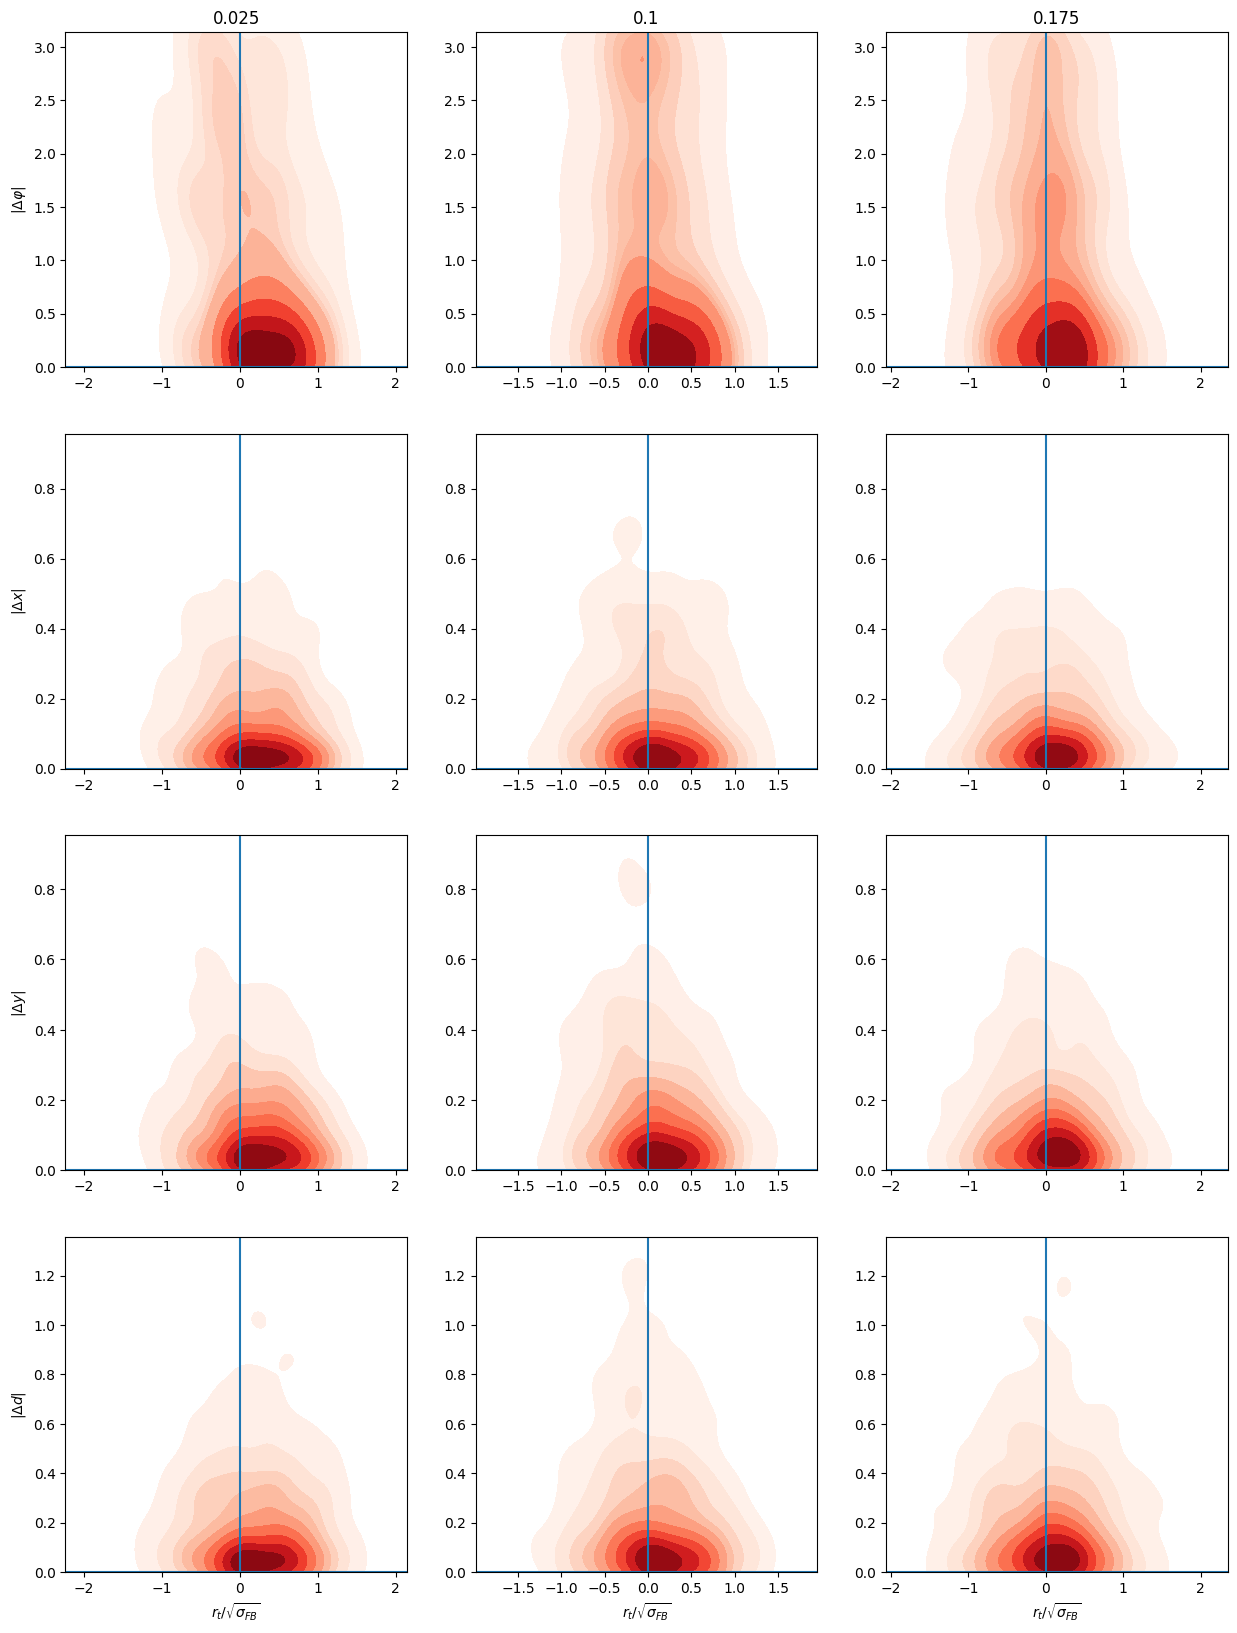

C:\Users\annic\AppData\Local\Temp\ipykernel_27216\2960974303.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["avg_diff"] = list(mydiff)
C:\Users\annic\AppData\Local\Temp\ipykernel_27216\2960974303.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["delta_gauges"] = list(dgaug)
C:\Users\annic\AppData\Local\Temp\ipykernel_27216\2960974303.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

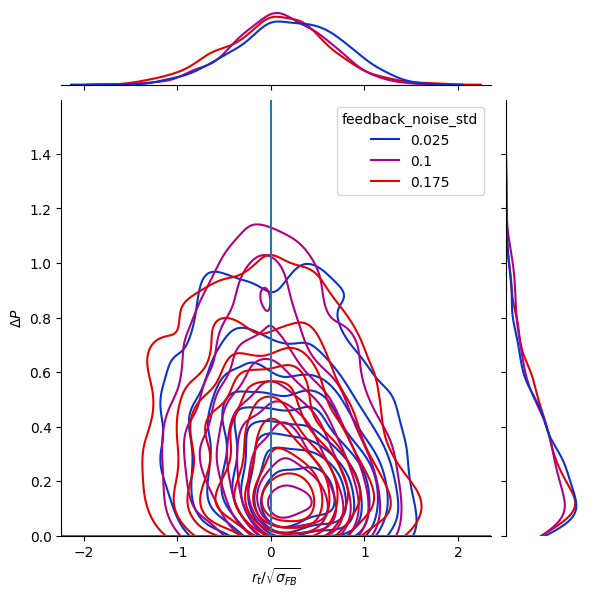

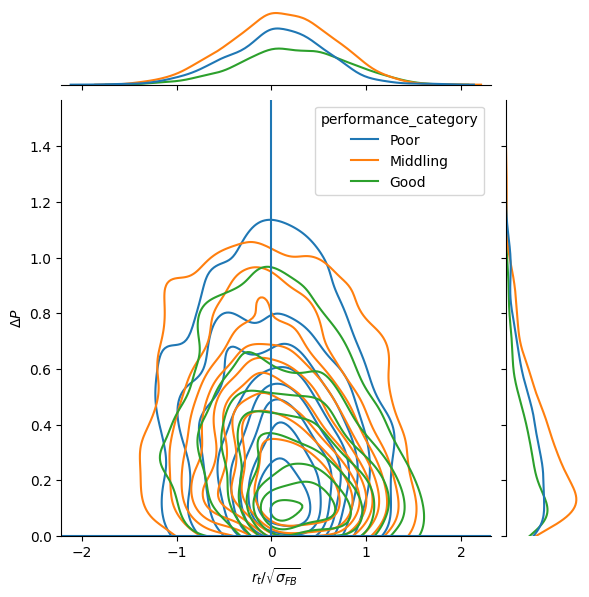

In [3]:
copy_df = subjects_df[subjects_df["study_name"]=="study_3"]

plot_normalized_deltas = True


look_between_a = 0
look_between_b = 2


# Difference between raw points at times t and t+1
points = np.stack(copy_df["raw_points"])
Nsubj,Ntrials,Nactions,Npoints,Nfeatures = points.shape

points_1 = points[...,0,:2]
points_2 = points[...,1,:2]
dist_points1 = np.linalg.norm(points_1[:,:,:-1,:] - points_1[:,:,1:,:],axis=-1)[:,look_between_a:look_between_b]
dist_points2 = np.linalg.norm(points_2[:,:,:-1,:] - points_2[:,:,1:,:],axis=-1)[:,look_between_a:look_between_b]
avg_dist = (dist_points1 + dist_points2)/2.0
flattened_distance = np.reshape(avg_dist,(Nsubj,-1))


# Observations : 
list_of_subjects_rtf = list(copy_df["realtime_values"])
all_subject_obs = {"gauge_level":[],"delta_gauge":[]}
for _s,_subj_feedback_series in enumerate(list_of_subjects_rtf):                   
    list_of_last_fb = []
    list_of_deltas = []
    for trial_series in _subj_feedback_series:
        trial_last_fbs = []
        trial_delta_fbs = []
        for timestep_series in trial_series:
            initial_feedback_value = timestep_series[0][...,1]
            final_feedback_value = timestep_series[-1][...,1]
            
            # print(timestep_series[0,:])
            
            trial_last_fbs.append(final_feedback_value)
            
            delta_feedback = final_feedback_value - initial_feedback_value
            trial_delta_fbs.append(delta_feedback)
                
        list_of_last_fb.append(trial_last_fbs)
        list_of_deltas.append(trial_delta_fbs)
    
    all_subject_obs["gauge_level" ].append(np.array(list_of_last_fb))
    all_subject_obs["delta_gauge" ].append(np.array(list_of_deltas))

# Action data :
all_barycenters = np.stack(copy_df["action_barycenters"],axis=0)
all_angles = np.stack(copy_df["action_angles"],axis=0)
all_distances = np.stack(copy_df["action_distances"],axis=0)
all_dist_to_center = vmap(vmap(vmap(lambda x : jnp.linalg.norm(x-jnp.array([0.5,0.5])))))(all_barycenters)

# Observation data :
gauge_levels = np.array(all_subject_obs["gauge_level"])
delta_gauges = np.array(all_subject_obs["delta_gauge"])

positive_feedbacks = delta_gauges>=0
negative_feedbacks = delta_gauges<0


# Differences between barycenters at time t and time t+1 :
diff_barycenters = np.linalg.norm(all_barycenters[:,:,1:,:] - all_barycenters[:,:,:-1,:],axis=-1)
# Differences between angles at time t and time t+1 :
diff_angle = all_angles[:,:,1:] - all_angles[:,:,:-1]

# All diff angles > pi are counted as value -2pi
diff_angle[diff_angle>np.pi] += - 2*np.pi
# All diff angles < -pi are counted as value +2pi
diff_angle[diff_angle< -np.pi] += 2*np.pi

# Differences between distances at time t and time t+1 :
diff_distances = all_distances[:,:,1:] - all_distances[:,:,:-1]
Nsubj = diff_barycenters.shape[0]

# Get the actions of interest :
rdiff_angle = np.reshape(diff_angle[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_barycenters = np.reshape(diff_barycenters[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_distances = np.reshape(diff_distances[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_points = np.reshape(avg_dist[:,look_between_a:look_between_b],(Nsubj,-1))

label = 'angle'
modality = all_angles   

# for label,modality in zip(["angle","position_x","position_y","distance"],[all_angles,all_barycenters[...,0],all_barycenters[...,1],all_distances]):
#     dgaug = np.reshape(delta_gauges[...,:-1][:,look_between_a:look_between_b],(Nsubj,-1))
#     next_act = np.reshape(modality[:,look_between_a:look_between_b],(Nsubj,-1))
#     print(dgaug.shape)
#     print(next_act.shape)
#     plt.scatter(dgaug,next_act,alpha = 0.1)
#     plt.title("Next {} based on feedback received".format(label))
#     plt.xlabel("Feedback received")
#     plt.ylabel("{} action performed".format(label))
#     plt.show()
    
    
fig,axs = plt.subplots(4,3,figsize=(15,20))

for i,(label,modality,latexlabel) in enumerate(zip(["angle","position_x","position_y","distance"],[all_angles,all_barycenters[...,0],all_barycenters[...,1],all_distances],[r"$ \Delta \varphi $",r"$ \Delta x $",r"$ \Delta y $",r"$ \Delta d $"])):
    dgaug = np.reshape(delta_gauges[...,1:-1][:,look_between_a:look_between_b],(Nsubj,-1))
    diff = modality[:,:,1:] - modality[:,:,:-1]  # Difference betweeen successive actions 
    
    if label == 'angle':
        # All diff angles > pi are counted as value -2pi
        diff[diff>np.pi] += - 2*np.pi
        # All diff angles < -pi are counted as value +2pi
        diff[diff< -np.pi] += 2*np.pi

    
    dnext_act = np.abs(np.reshape(diff[:,look_between_a:look_between_b],(Nsubj,-1)))
    
    plot_df = copy_df[["subject_id","final_performance","feedback_noise_std"]]
    plot_df[label] = list(dnext_act)
    plot_df["delta_gauges"] = list(dgaug)
    exploded_df = plot_df.explode([label, 'delta_gauges'])
    exploded_df['delta_gauges_norm'] = exploded_df['delta_gauges'] / np.sqrt(exploded_df["feedback_noise_std"])
    
    for ax in axs[i,:]:
        # ax.set_xlim([-0.5,0.5])
        ax.set_ylim([np.min(exploded_df[label]),np.max(exploded_df[label])])
    
    fbs_noises = [0.025,0.1 ,0.175]
    for k,fb_std in enumerate(fbs_noises):
        ax = axs[i,k]
        if i == 0:
            ax.set_title(fb_std)
        
        
        
        ax.axvline(0)
        ax.axhline(0)
        
        
        if plot_normalized_deltas : 
            sns.kdeplot(ax=ax,data = exploded_df[exploded_df['feedback_noise_std']==fb_std],x = "delta_gauges_norm",y=label, cmap='Reds',fill=True)
        else : 
            sns.kdeplot(ax=ax,data = exploded_df[exploded_df['feedback_noise_std']==fb_std],x = "delta_gauges",y=label, cmap='Reds',fill=True)
        if k == 0:
            ax.set_ylabel("|"+ latexlabel + "|")
        else : 
            ax.set_ylabel("")
        if i == 3 :
            if plot_normalized_deltas : 
                ax.set_xlabel("$r_t / \sqrt{\sigma_{FB}}$")
            else:
                ax.set_xlabel("$r_t$")
        else : 
            ax.set_xlabel("")
            
plt.show()






avg_dist = (dist_points1 + dist_points2)/2.0
dgaug = np.reshape(delta_gauges[...,1:-1][:,look_between_a:look_between_b],(Nsubj,-1))
mydiff = np.reshape(avg_dist,(Nsubj,-1))

plot_df = copy_df[["subject_id","final_performance","feedback_noise_std","performance_category"]]
plot_df["avg_diff"] = list(mydiff)
plot_df["delta_gauges"] = list(dgaug)
plot_df["ndelta_gauges"] = plot_df["delta_gauges"] / np.sqrt(plot_df["feedback_noise_std"])
exploded_df = plot_df.explode(["avg_diff", 'delta_gauges','ndelta_gauges'])

NOISE_COLORMAP = [[c/256.0 for c in col] for col in [[10, 51, 204],[179, 0, 134],[230, 0, 0]]]
color_dict = {cat: np.array(NOISE_COLORMAP[k]) for k,cat in enumerate([0.025,0.1,0.175])}
if plot_normalized_deltas:
    sns.jointplot(
        data=exploded_df,
        x="ndelta_gauges", y="avg_diff", hue="feedback_noise_std",
        kind="kde",palette=color_dict
    )
    plt.xlabel("$r_t / \sqrt{\sigma_{FB}}$")
else : 
    sns.jointplot(
        data=exploded_df,
        x="delta_gauges", y="avg_diff", hue="feedback_noise_std",
        kind="kde",palette=color_dict
    )
    plt.xlabel(r"$r_t$")
plt.axvline(0)
plt.axhline(0)
plt.ylim(bottom=0)
plt.ylabel(r"$\Delta P$")
plt.show()


hue_order = ["Poor","Middling","Good"]
if plot_normalized_deltas:
    sns.jointplot(
        data=exploded_df,
        x="ndelta_gauges", y="avg_diff", hue="performance_category",hue_order=hue_order,
        kind="kde"
    )
    plt.xlabel("$r_t / \sqrt{\sigma_{FB}}$")
else : 
    sns.jointplot(
        data=exploded_df,
        x="delta_gauges", y="avg_diff", hue="performance_category",hue_order=hue_order,
        kind="kde" 
    )
    plt.xlabel(r"$r_t$")
plt.axvline(0)
plt.axhline(0)
plt.ylim(bottom=0)
plt.ylabel(r"$\Delta P$")
plt.show()


C:\Users\annic\AppData\Local\Temp\ipykernel_27216\2547320185.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[label] = list(dnext_act)
C:\Users\annic\AppData\Local\Temp\ipykernel_27216\2547320185.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["delta_gauges"] = list(dgaug)
C:\Users\annic\AppData\Local\Temp\ipykernel_27216\2547320185.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

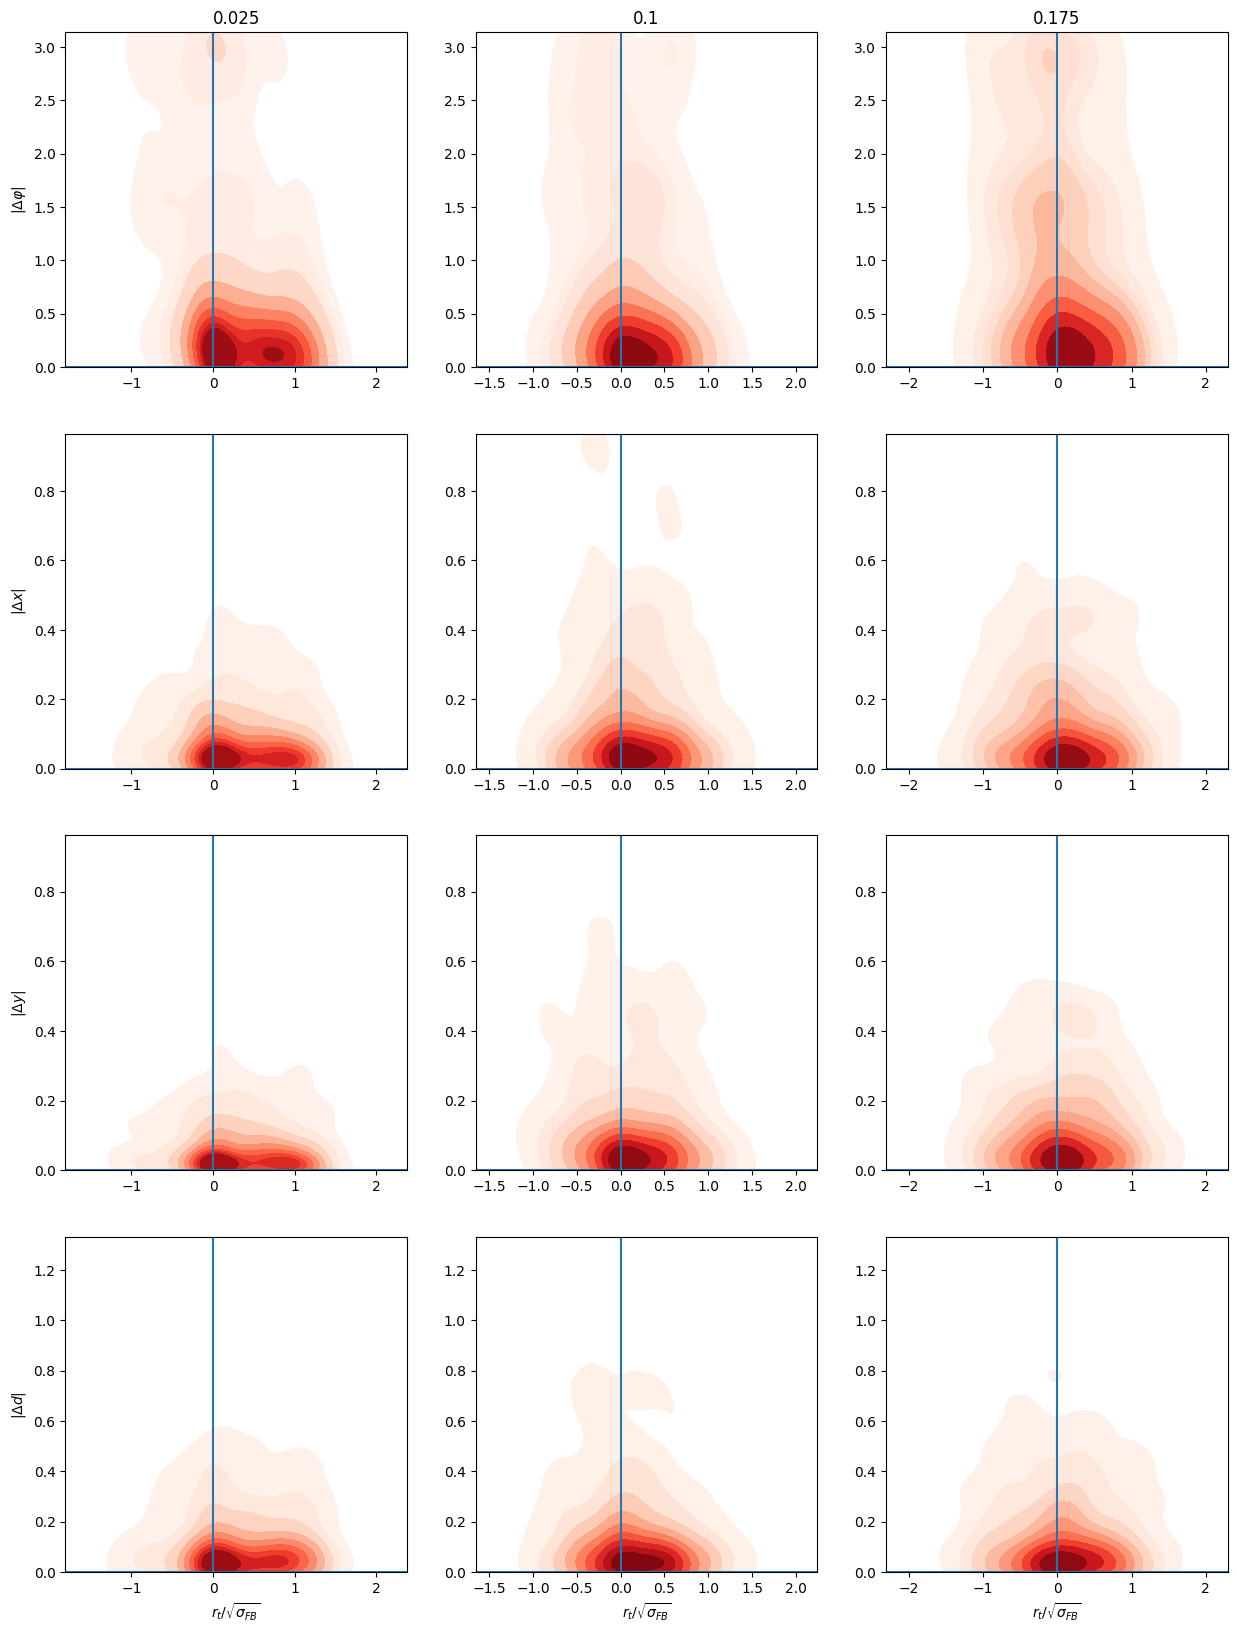

C:\Users\annic\AppData\Local\Temp\ipykernel_27216\2547320185.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["avg_diff"] = list(mydiff)
C:\Users\annic\AppData\Local\Temp\ipykernel_27216\2547320185.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["delta_gauges"] = list(dgaug)
C:\Users\annic\AppData\Local\Temp\ipykernel_27216\2547320185.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

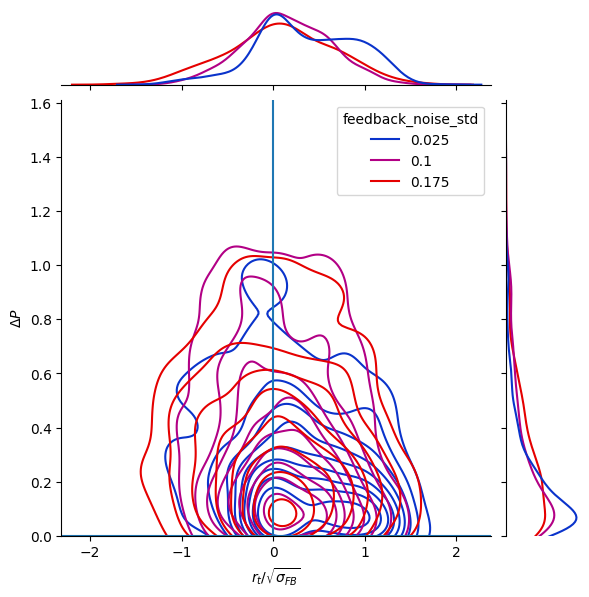

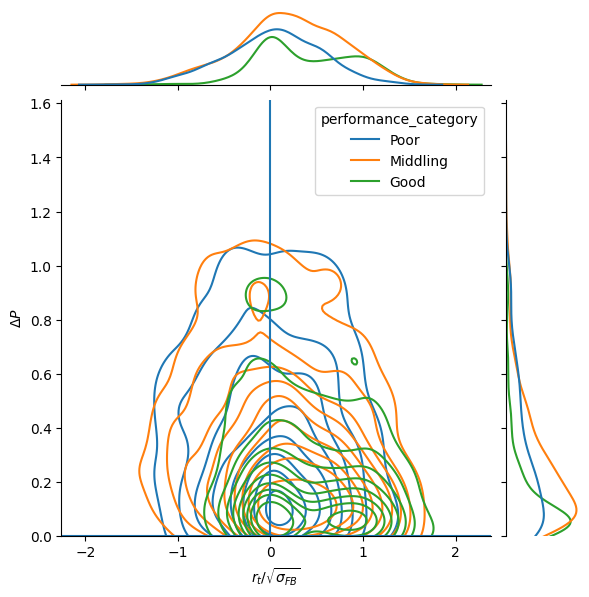

In [4]:
copy_df = subjects_df[subjects_df["study_name"]=="study_3"]

plot_normalized_deltas = True


look_between_a = 7
look_between_b = 9


# Difference between raw points at times t and t+1
points = np.stack(copy_df["raw_points"])
Nsubj,Ntrials,Nactions,Npoints,Nfeatures = points.shape

points_1 = points[...,0,:2]
points_2 = points[...,1,:2]
dist_points1 = np.linalg.norm(points_1[:,:,:-1,:] - points_1[:,:,1:,:],axis=-1)[:,look_between_a:look_between_b]
dist_points2 = np.linalg.norm(points_2[:,:,:-1,:] - points_2[:,:,1:,:],axis=-1)[:,look_between_a:look_between_b]
avg_dist = (dist_points1 + dist_points2)/2.0
flattened_distance = np.reshape(avg_dist,(Nsubj,-1))


# Observations : 
list_of_subjects_rtf = list(copy_df["realtime_values"])
all_subject_obs = {"gauge_level":[],"delta_gauge":[]}
for _s,_subj_feedback_series in enumerate(list_of_subjects_rtf):                   
    list_of_last_fb = []
    list_of_deltas = []
    for trial_series in _subj_feedback_series:
        trial_last_fbs = []
        trial_delta_fbs = []
        for timestep_series in trial_series:
            initial_feedback_value = timestep_series[0][...,1]
            final_feedback_value = timestep_series[-1][...,1]
            
            # print(timestep_series[0,:])
            
            trial_last_fbs.append(final_feedback_value)
            
            delta_feedback = final_feedback_value - initial_feedback_value
            trial_delta_fbs.append(delta_feedback)
                
        list_of_last_fb.append(trial_last_fbs)
        list_of_deltas.append(trial_delta_fbs)
    
    all_subject_obs["gauge_level" ].append(np.array(list_of_last_fb))
    all_subject_obs["delta_gauge" ].append(np.array(list_of_deltas))

# Action data :
all_barycenters = np.stack(copy_df["action_barycenters"],axis=0)
all_angles = np.stack(copy_df["action_angles"],axis=0)
all_distances = np.stack(copy_df["action_distances"],axis=0)
all_dist_to_center = vmap(vmap(vmap(lambda x : jnp.linalg.norm(x-jnp.array([0.5,0.5])))))(all_barycenters)

# Observation data :
gauge_levels = np.array(all_subject_obs["gauge_level"])
delta_gauges = np.array(all_subject_obs["delta_gauge"])

positive_feedbacks = delta_gauges>=0
negative_feedbacks = delta_gauges<0


# Differences between barycenters at time t and time t+1 :
diff_barycenters = np.linalg.norm(all_barycenters[:,:,1:,:] - all_barycenters[:,:,:-1,:],axis=-1)
# Differences between angles at time t and time t+1 :
diff_angle = all_angles[:,:,1:] - all_angles[:,:,:-1]

# All diff angles > pi are counted as value -2pi
diff_angle[diff_angle>np.pi] += - 2*np.pi
# All diff angles < -pi are counted as value +2pi
diff_angle[diff_angle< -np.pi] += 2*np.pi

# Differences between distances at time t and time t+1 :
diff_distances = all_distances[:,:,1:] - all_distances[:,:,:-1]
Nsubj = diff_barycenters.shape[0]

# Get the actions of interest :
rdiff_angle = np.reshape(diff_angle[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_barycenters = np.reshape(diff_barycenters[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_distances = np.reshape(diff_distances[:,look_between_a:look_between_b],(Nsubj,-1))
rdiff_points = np.reshape(avg_dist[:,look_between_a:look_between_b],(Nsubj,-1))

label = 'angle'
modality = all_angles   

# for label,modality in zip(["angle","position_x","position_y","distance"],[all_angles,all_barycenters[...,0],all_barycenters[...,1],all_distances]):
#     dgaug = np.reshape(delta_gauges[...,:-1][:,look_between_a:look_between_b],(Nsubj,-1))
#     next_act = np.reshape(modality[:,look_between_a:look_between_b],(Nsubj,-1))
#     print(dgaug.shape)
#     print(next_act.shape)
#     plt.scatter(dgaug,next_act,alpha = 0.1)
#     plt.title("Next {} based on feedback received".format(label))
#     plt.xlabel("Feedback received")
#     plt.ylabel("{} action performed".format(label))
#     plt.show()
    
    
fig,axs = plt.subplots(4,3,figsize=(15,20))

for i,(label,modality,latexlabel) in enumerate(zip(["angle","position_x","position_y","distance"],[all_angles,all_barycenters[...,0],all_barycenters[...,1],all_distances],[r"$ \Delta \varphi $",r"$ \Delta x $",r"$ \Delta y $",r"$ \Delta d $"])):
    dgaug = np.reshape(delta_gauges[...,1:-1][:,look_between_a:look_between_b],(Nsubj,-1))
    diff = modality[:,:,1:] - modality[:,:,:-1]  # Difference betweeen successive actions 
    
    if label == 'angle':
        # All diff angles > pi are counted as value -2pi
        diff[diff>np.pi] += - 2*np.pi
        # All diff angles < -pi are counted as value +2pi
        diff[diff< -np.pi] += 2*np.pi

    
    dnext_act = np.abs(np.reshape(diff[:,look_between_a:look_between_b],(Nsubj,-1)))
    
    plot_df = copy_df[["subject_id","final_performance","feedback_noise_std"]]
    plot_df[label] = list(dnext_act)
    plot_df["delta_gauges"] = list(dgaug)
    exploded_df = plot_df.explode([label, 'delta_gauges'])
    exploded_df['delta_gauges_norm'] = exploded_df['delta_gauges'] / np.sqrt(exploded_df["feedback_noise_std"])
    
    for ax in axs[i,:]:
        # ax.set_xlim([-0.5,0.5])
        ax.set_ylim([np.min(exploded_df[label]),np.max(exploded_df[label])])
    
    fbs_noises = [0.025,0.1 ,0.175]
    for k,fb_std in enumerate(fbs_noises):
        ax = axs[i,k]
        if i == 0:
            ax.set_title(fb_std)
        
        
        
        ax.axvline(0)
        ax.axhline(0)
        
        
        if plot_normalized_deltas : 
            sns.kdeplot(ax=ax,data = exploded_df[exploded_df['feedback_noise_std']==fb_std],x = "delta_gauges_norm",y=label, cmap='Reds',fill=True)
        else : 
            sns.kdeplot(ax=ax,data = exploded_df[exploded_df['feedback_noise_std']==fb_std],x = "delta_gauges",y=label, cmap='Reds',fill=True)
        if k == 0:
            ax.set_ylabel("|"+ latexlabel + "|")
        else : 
            ax.set_ylabel("")
        if i == 3 :
            if plot_normalized_deltas : 
                ax.set_xlabel("$r_t / \sqrt{\sigma_{FB}}$")
            else:
                ax.set_xlabel("$r_t$")
        else : 
            ax.set_xlabel("")
            
plt.show()




avg_dist = (dist_points1 + dist_points2)/2.0
dgaug = np.reshape(delta_gauges[...,1:-1][:,look_between_a:look_between_b],(Nsubj,-1))
mydiff = np.reshape(avg_dist,(Nsubj,-1))

plot_df = copy_df[["subject_id","final_performance","feedback_noise_std","performance_category"]]
plot_df["avg_diff"] = list(mydiff)
plot_df["delta_gauges"] = list(dgaug)
plot_df["ndelta_gauges"] = plot_df["delta_gauges"] / np.sqrt(plot_df["feedback_noise_std"])
exploded_df = plot_df.explode(["avg_diff", 'delta_gauges','ndelta_gauges'])

NOISE_COLORMAP = [[c/256.0 for c in col] for col in [[10, 51, 204],[179, 0, 134],[230, 0, 0]]]
color_dict = {cat: np.array(NOISE_COLORMAP[k]) for k,cat in enumerate([0.025,0.1,0.175])}
if plot_normalized_deltas:
    sns.jointplot(
        data=exploded_df,
        x="ndelta_gauges", y="avg_diff", hue="feedback_noise_std",
        kind="kde",palette=color_dict
    )
    plt.xlabel("$r_t / \sqrt{\sigma_{FB}}$")
else : 
    sns.jointplot(
        data=exploded_df,
        x="delta_gauges", y="avg_diff", hue="feedback_noise_std",
        kind="kde",palette=color_dict
    )
    plt.xlabel(r"$r_t$")
plt.axvline(0)
plt.axhline(0)
plt.ylim(bottom=0)
plt.ylabel(r"$\Delta P$")
plt.show()


hue_order = ["Poor","Middling","Good"]
if plot_normalized_deltas:
    sns.jointplot(
        data=exploded_df,
        x="ndelta_gauges", y="avg_diff", hue="performance_category",hue_order=hue_order,
        kind="kde"
    )
    plt.xlabel("$r_t / \sqrt{\sigma_{FB}}$")
else : 
    sns.jointplot(
        data=exploded_df,
        x="delta_gauges", y="avg_diff", hue="performance_category",hue_order=hue_order,
        kind="kde" 
    )
    plt.xlabel(r"$r_t$")
plt.axvline(0)
plt.axhline(0)
plt.ylim(bottom=0)
plt.ylabel(r"$\Delta P$")
plt.show()
